In [8]:
import os
from datetime import datetime, timedelta

import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.dates as mdates

In [2]:
from constants import ONTARIO_CITIES

RQ1: How many days per year are in each health risk category using maximum daily AQHI, for each city? Is it increasing?

/tmp/ipykernel_1221848/1395852218.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(ONTARIO_CITIES))


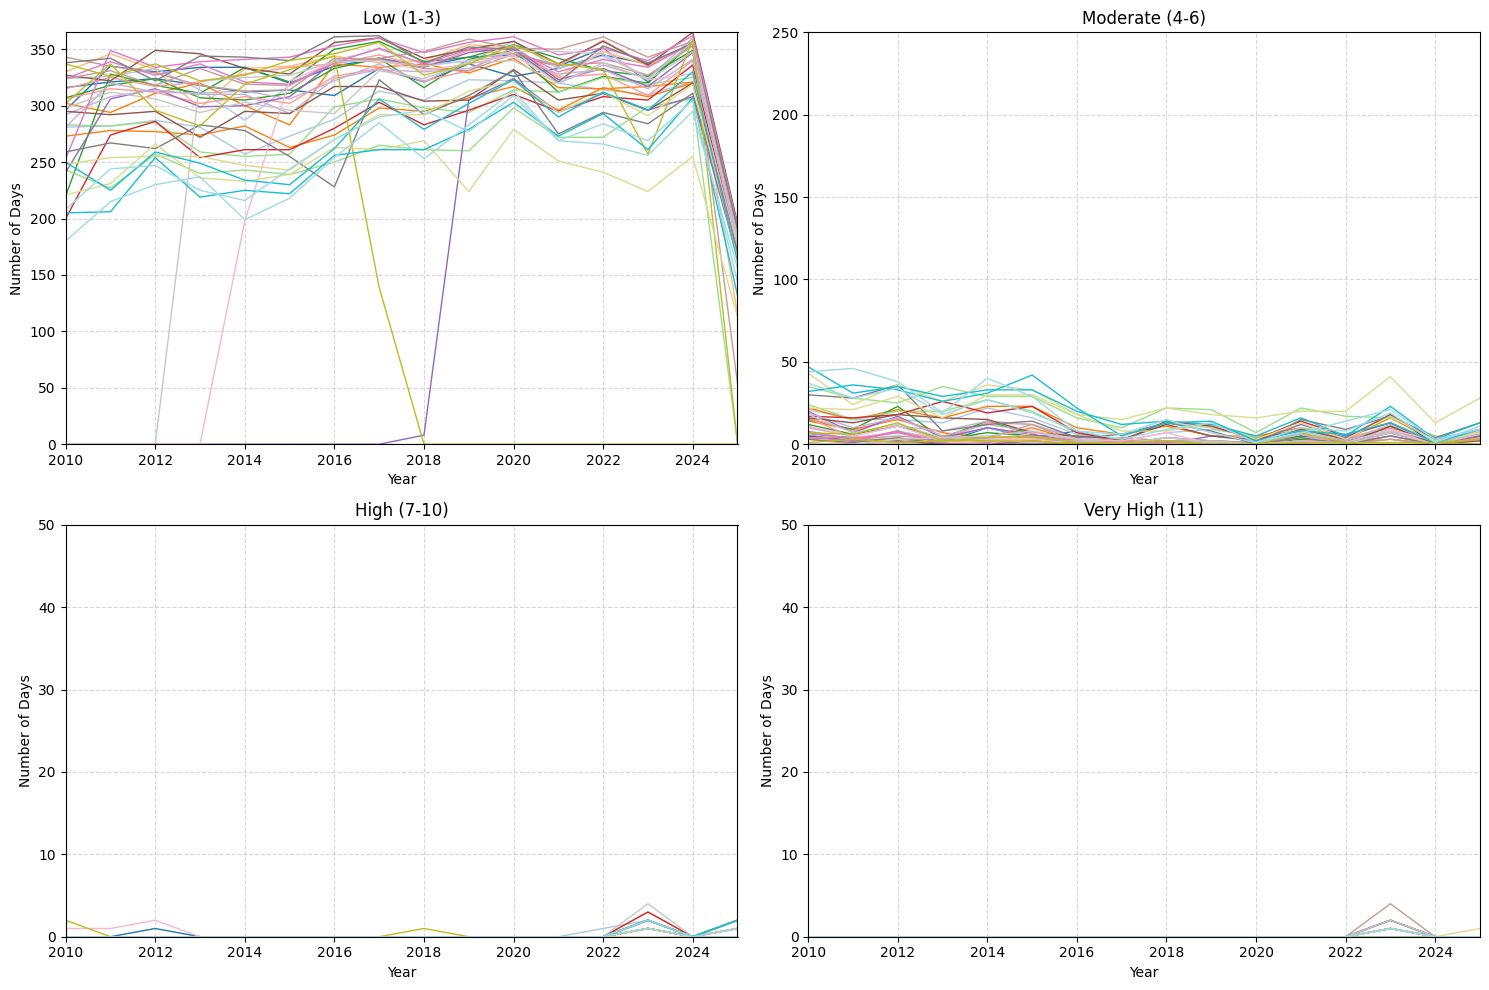

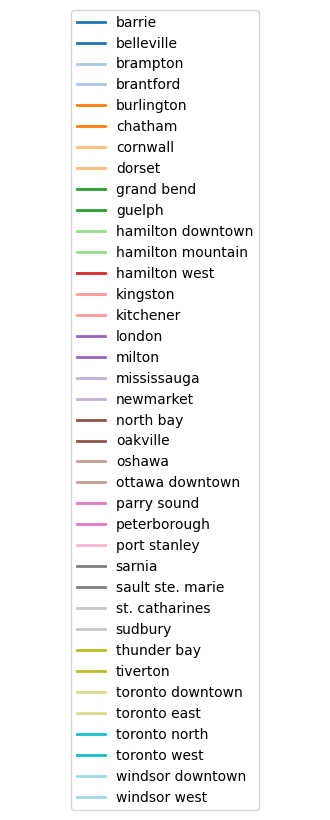

In [7]:
# Define AQHI ranges for each category
categories = {
    'Low (1-3)': ((1, 3), (0, 365)),
    'Moderate (4-6)': ((4, 6), (0, 250)),
    'High (7-10)': ((7, 10), (0, 50)),
    'Very High (11)': ((11, 11), (0, 50))  # 11 = public-facing "10+"
}

years = list(range(2010, 2026))  # limit years to 2010–2025

# Create color map for cities
cmap = cm.get_cmap('tab20', len(ONTARIO_CITIES))
colors = {city: cmap(i) for i, city in enumerate(ONTARIO_CITIES)}

# Prepare figure for the 4 plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=False, sharey=False)
axes = axes.flatten()

for ax, (cat_name, ((low, high), (ymin, ymax))) in zip(axes, categories.items()):
    for city in ONTARIO_CITIES:
        daily_path = f'../../data/processed/ontario/daily/{city}.csv'
        if not os.path.exists(daily_path):
            continue
        
        df_daily = pd.read_csv(daily_path, index_col=0, parse_dates=True)
        if 'mean_aqhi' not in df_daily.columns:
            continue

        # Filter rows within category range
        mask = (df_daily['mean_aqhi'] >= low) & (df_daily['mean_aqhi'] <= high)
        df_filtered = df_daily[mask]

        # Count number of days per year
        yearly_counts = df_filtered.groupby(df_filtered.index.year).size()
        yearly_counts = yearly_counts.reindex(years, fill_value=0)

        ax.plot(years, yearly_counts, color=colors[city], linewidth=1)

    ax.set_title(cat_name)
    ax.set_xlabel('Year')
    ax.set_ylabel('Number of Days')
    ax.set_xlim(2010, 2025)
    ax.set_ylim(ymin, ymax)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Separate legend figure
fig_legend, ax_legend = plt.subplots(figsize=(4, 10))
handles = [plt.Line2D([0], [0], color=colors[city], lw=2) for city in ONTARIO_CITIES]
ax_legend.legend(handles, ONTARIO_CITIES, loc='center')
ax_legend.axis('off')

plt.show()


What is the rolling (3h) hourly AQHI in a given city? Compare the periods 2023-2025 and 2013-2015. 

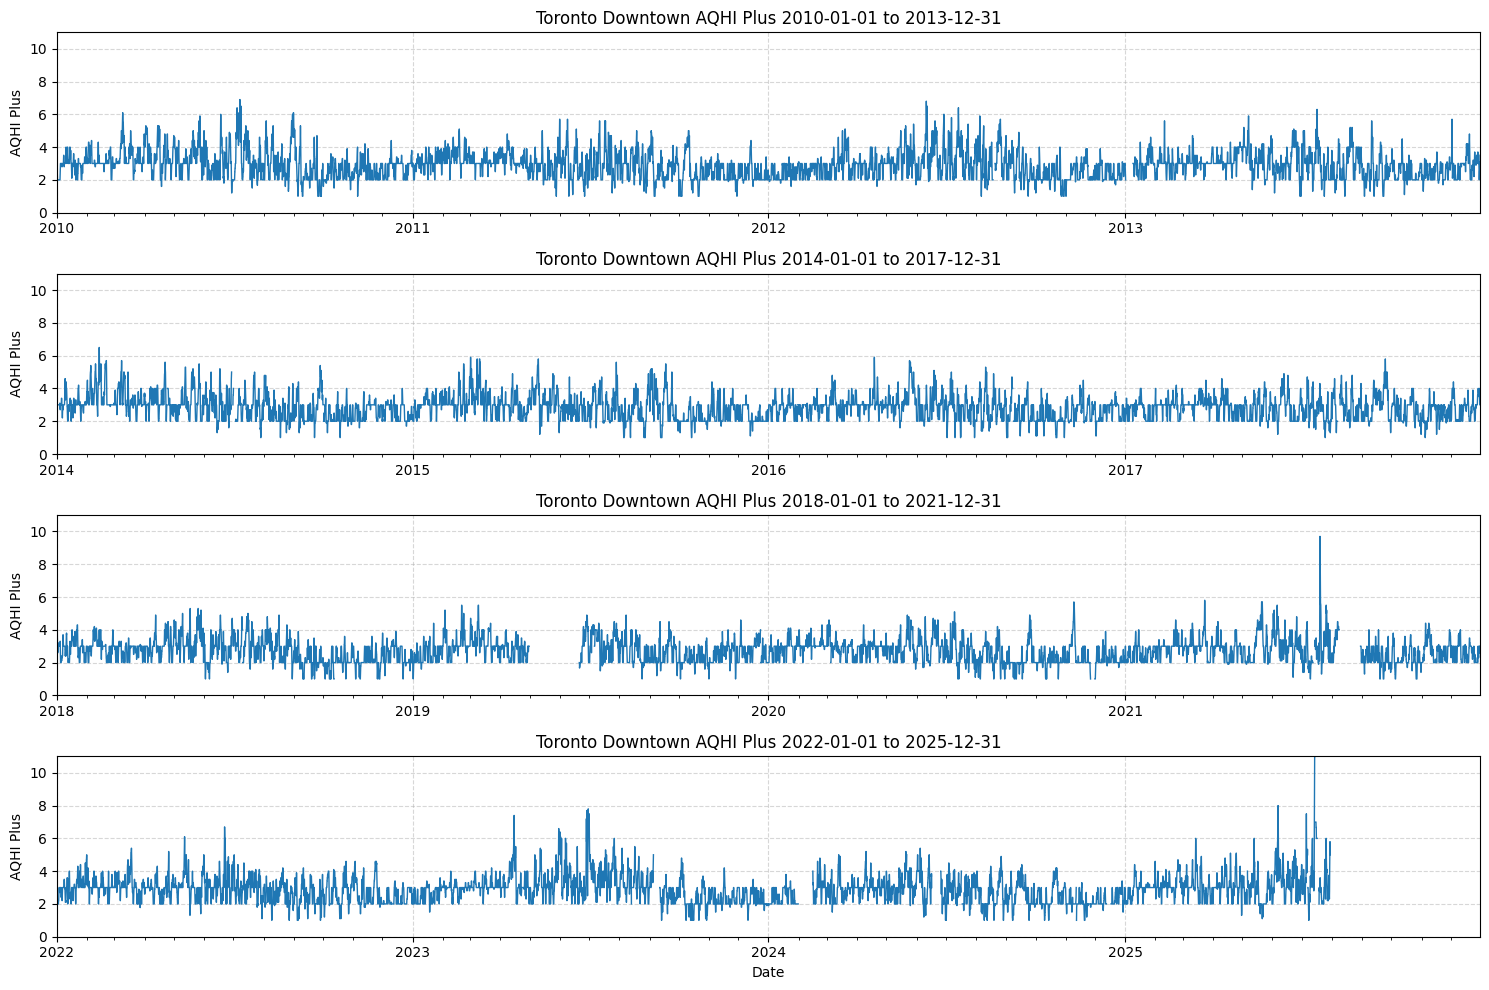

In [18]:
city = "toronto downtown"

hourly_path = f'../../data/processed/ontario/hourly/{city}.csv'

# Load data
df_hourly = pd.read_csv(hourly_path, index_col=0, parse_dates=True)

# Apply 3-hour rolling average
df_hourly['aqhi_plus_smooth'] = df_hourly['aqhi_plus'].rolling(window=10, min_periods=1).mean()

# Define the periods
periods = [
    ("2010-01-01", "2013-12-31"),
    ("2014-01-01", "2017-12-31"),
    ("2018-01-01", "2021-12-31"),
    ("2022-01-01", "2025-12-31")
]

# Plotting: 4 rows, 1 column
fig, axes = plt.subplots(len(periods), 1, figsize=(15, 10), sharey=True)

if len(periods) == 1:
    axes = [axes]  # Ensure iterable

for ax, (start_date, end_date) in zip(axes, periods):
    # Create full hourly index for the period
    full_index = pd.date_range(start=start_date, end=end_date, freq="h")

    # Slice data and reindex to full period
    mask = (df_hourly.index >= start_date) & (df_hourly.index <= end_date)
    df_period = df_hourly.loc[mask].reindex(full_index)

    # Plot
    ax.plot(df_period.index, df_period['aqhi_plus_smooth'], color='tab:blue', linewidth=1)
    ax.set_title(f"{city.title()} AQHI Plus {start_date} to {end_date}")
    ax.set_ylabel("AQHI Plus")
    ax.set_ylim(0, 11)  # consistent y-scale
    ax.set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))  # force full width

    # Format x-axis: major ticks = years, minor ticks = every 4 months
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonth=list(range(1, 13))))  

    ax.grid(True, linestyle='--', alpha=0.5)

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()
